In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the .npy file
# loaded_array = np.load('dataset_newsim_2x500x500_crop100.npy')
loaded_array = np.load('dataset_oldsim_2x100x500_crop9087.npy')
train_data = loaded_array[:800,:1].transpose(0,2,3,1)
test_data = loaded_array[900:,:1].transpose(0,2,3,1)
train_data = (train_data - np.mean(train_data, axis=(-3,-2), keepdims=True) )/ (np.std(train_data, axis=(-3,-2), keepdims=True) +1)
test_data = (test_data - np.mean(test_data, axis=(-3,-2), keepdims=True) )/ (np.std(test_data, axis=(-3,-2), keepdims=True) +1)
# train_data = (train_data - np.min(train_data, axis=(-3,-2), keepdims=True)) / (np.max(train_data, axis=(-3,-2), keepdims=True) - np.min(train_data, axis=(-2,-3), keepdims=True))
# Now, `loaded_array` is a numpy array containing the data from the .npy file

print(train_data.shape)
train_data = np.repeat(train_data, 5, axis=1)
test_data = np.repeat(test_data, 5, axis=1)
print(train_data.shape)



/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/numpy/core/_methods.py:213: RuntimeWarning: overflow encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True, where=where)
/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
/var/folders/bt/1cqt3cks1sl9cz4dfwlyxhpm0000gn/T/ipykernel_49794/544335303.py:11: RuntimeWarning: invalid value encountered in subtract
  test_data = (test_data - np.mean(test_data, axis=(-3,-2), keepdims=True) )/ (np.std(test_data, axis=(-3,-2), keepdims=True) +1)
/Users/mo2016/Documents/modelling/growth/src/neural_net_classification/venv/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


(800, 100, 500, 1)
(800, 500, 500, 1)


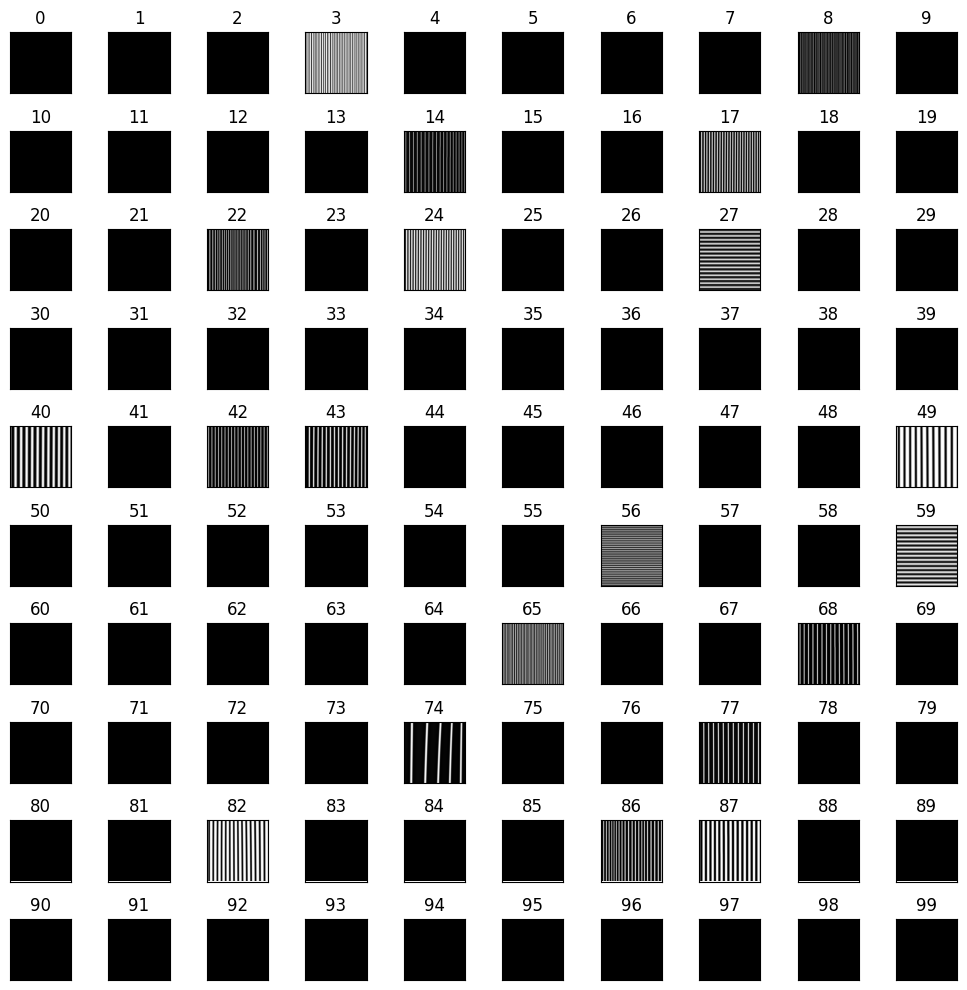

In [38]:
import matplotlib.pyplot as plt

n = 9087
num_rows = 10  # Define the number of rows
num_cols = 10  # Define the number of rows
plt.figure(figsize=(num_cols,num_rows))

counter = 0
for column in range(num_cols):
    for row in range(num_rows):
        ax = plt.subplot(num_rows, num_cols,counter+1)
        plt.imshow(train_data[counter])
        plt.title(f"{counter}")

        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        counter += 1

plt.tight_layout()
plt.show()


In [3]:
noise_factor = 0.2
x_train_noisy = train_data + noise_factor * tf.random.normal(shape=train_data.shape) 
x_test_noisy = test_data + noise_factor * tf.random.normal(shape=test_data.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

2024-03-12 23:20:29.958090: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-12 23:20:29.958358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


: 

In [3]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data))
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_data))

2024-03-12 23:19:07.863031: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-12 23:19:07.863634: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
BATCH_SIZE = 4 
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

NameError: name 'train_dataset' is not defined

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(500, 500, 1)),
      layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (5, 5), activation='relu', padding='same', strides=5),
      layers.Flatten(),
      layers.Dense(3)])

    self.decoder = tf.keras.Sequential([
      layers.Input(shape=(3,)),
      layers.Dense(25*25*8, activation='relu'),
      layers.Reshape((25, 25, 8)),
      layers.Conv2DTranspose(8, kernel_size=5, strides=5, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

2024-03-12 23:11:38.023508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 23:11:41.084245: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-12 23:11:41.084819: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-4)
    
autoencoder.compile(optimizer=optimizer, loss=losses.MeanSquaredError())

In [9]:
autoencoder.fit(x_train_noisy, train_data,
                epochs=20,
                shuffle=True,
                
                )

NameError: name 'x_train_noisy' is not defined

In [10]:
z = autoencoder.encoder(train_data)
z.shape

TensorShape([80, 3])

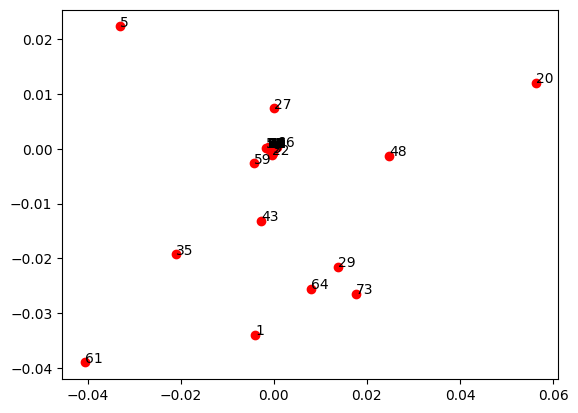

In [11]:
plt.scatter(z[:,0], z[:,1], c = 'r')
for index, z in enumerate(z):
    plt.text(z[0], z[1], str(index))

plt.show()

IndexError: index 16 is out of bounds for axis 0 with size 16

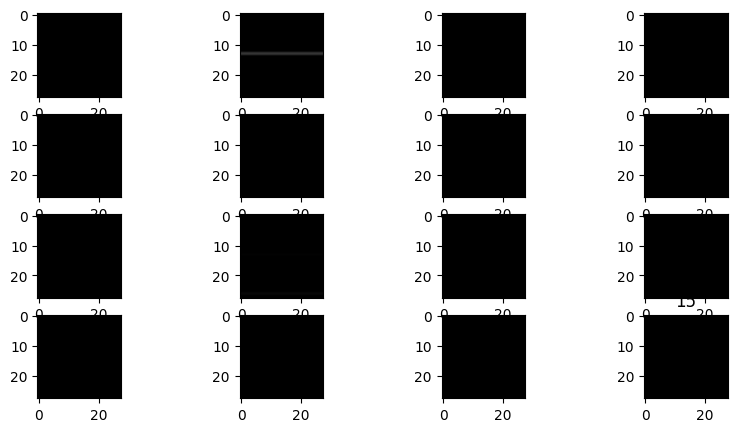

In [16]:
n = 78
fig, axs = plt.subplots(4, 4, figsize=(10, 5))
for i in range(n):
    ax = axs.flatten()[i]
    plt.title(i)
    ax.imshow(tf.squeeze(train_data[i]), vmin=0, vmax=train_data.max())
    plt.gray()
    
fig, axs = plt.subplots(4, 4, figsize=(10, 5))
axs = axs.flatten()
for i in range(n):
    ax = axs[i]
    plt.title(i)
    ax.imshow(tf.squeeze(train_data[i]), vmin=0, vmax=1)
    plt.gray()
plt.show()


-2.8037345


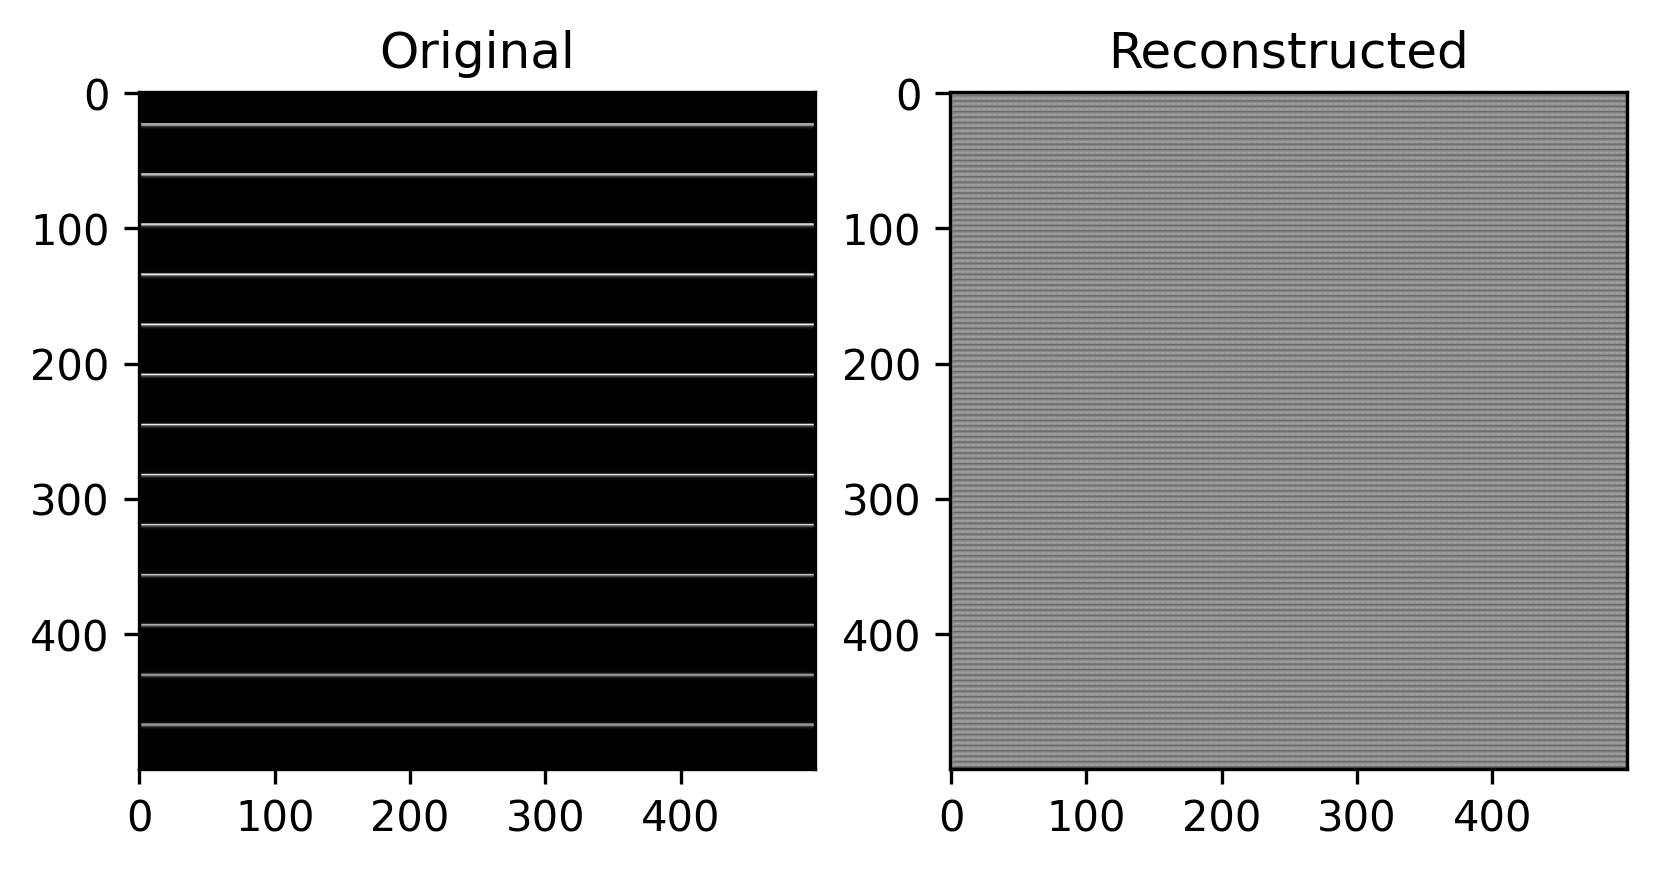

<tf.Tensor: shape=(500, 500, 1), dtype=float32, numpy=
array([[[ 1.4087725e-03],
        [ 3.2800210e-03],
        [ 3.9035729e-03],
        ...,
        [ 3.5683797e-03],
        [ 3.7980992e-03],
        [ 2.7674593e-03]],

       [[ 1.7548201e-04],
        [ 6.3827075e-04],
        [ 1.7712195e-04],
        ...,
        [ 6.4318301e-05],
        [-2.0811276e-04],
        [-5.8060919e-04]],

       [[-3.2053015e-04],
        [-7.5451320e-04],
        [-5.1585841e-05],
        ...,
        [-6.0971628e-04],
        [-6.8513688e-04],
        [-1.4714411e-03]],

       ...,

       [[ 1.8843601e-04],
        [ 6.5613276e-04],
        [ 5.6480092e-04],
        ...,
        [ 4.9760204e-04],
        [ 2.1496206e-04],
        [-6.0674769e-04]],

       [[-1.8406729e-04],
        [-8.8296284e-04],
        [-4.1511899e-04],
        ...,
        [-1.1773111e-03],
        [-9.7909092e-04],
        [-1.7924824e-03]],

       [[-1.3374627e-03],
        [-3.0829548e-03],
        [-4.1893721e-03],

In [14]:
x = train_data[61][None]
y = autoencoder(x)[0]
print(np.sum(y))

fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300)

ax1.imshow(tf.squeeze(x))
ax1.set_title('Original')

ax2.imshow(tf.squeeze(y))
ax2.set_title('Reconstructed')

plt.show()
y
